# 1. Basic potential flow

## Flow around a point vortex

The first step in creating *any* `GridPotentialFlow` model is to create a `PhysicalGrid` to discretize the domain.

In [1]:
using GridPotentialFlow
Δx = 0.01
xlim = (-1,1)
ylim = (-1,1)
g = PhysicalGrid(xlim,ylim,Δx);

The second step is to create our point vortex using `Vortex`.

In [2]:
v = Vortex(0.0,0.0,1.0);

Now we can create a `VortexModel` using the grid and an array containing the point vortex.

In [3]:
model = VortexModel(g,vortices=[v]);

The streamfunction field is then obtained using `computeψ`

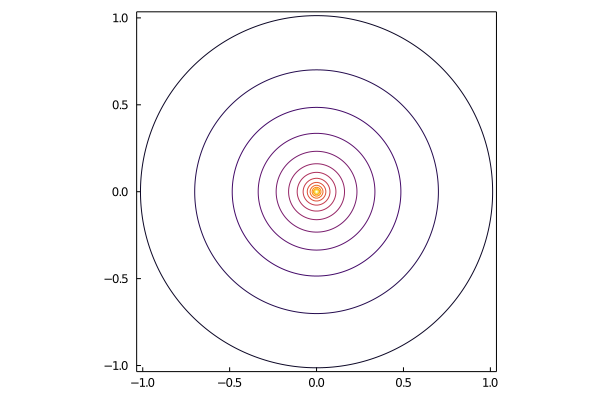

In [4]:
ψ = computeψ(model);
using Plots
plot(ψ,g)

The function `computeψ` returns a `Nodes` array. If we want to perform differential calculus operations this data, we can use the methods of that package. For example, we can easily obtain the velocity field from the streamfunction field using the `curl` operation.

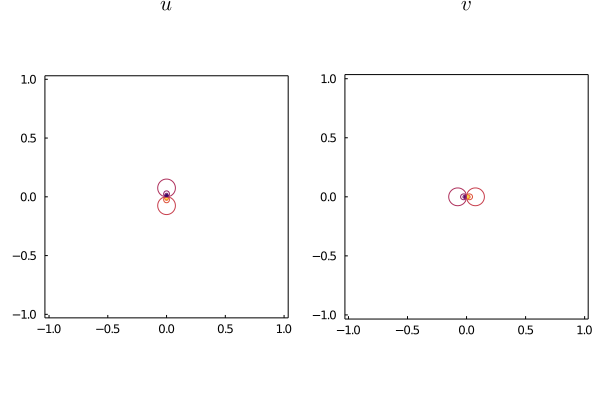

In [5]:
q = curl(ψ);
plot(q,g)

## Accuracy of the discretized Poisson equation

## Corotating point vortices
Now we will try advancing a vortex model in time. The simplest unsteady vortex model consists of two point vortices. When both point vortices have the same strength, they will rotate around each other on a trajectory that is easy to describe analytically. In this example, we will compare the analytical and simulated trajectories during one revolution.

First create two vortices at a distance $d$ from each other and give them a strength $\Gamma$

In [6]:
d = 1
Γ = 1
v1 = Vortex(d/2,0.0,Γ);
v2 = Vortex(-d/2,0.0,Γ);

We can analytically determine the time $T_v$ it takes for these vortices to complete one revolution around their centroid.

In [7]:
Vθ = Γ/(2*π*d); # Analytical tangential velocity
Tv = π*d/Vθ; # Analytical period

Let's now create a vortex model with the two point vortices.

In [8]:
model = VortexModel(g,vortices=[v1,v2]);

If we update the positions of the point vortices repeatedly to simulate the model advancing in time from $t=0$ to $t=T_v$, we can check if they end up again at their original positions.

In [9]:
Δt = 0.01
T = 0:Δt:Tv

0.0:0.01:19.73

To step in time, we update the positions as $X^{n+1}_v = X^{n}_v + Δt Ẋ^{n}_v$ (forward Euler) in a for-loop.

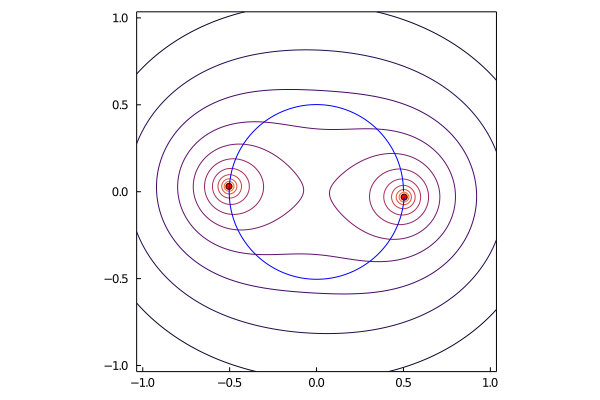

In [10]:
X_hist = []
for t in T
    Ẋ = computevortexvelocities(model)
    vortices = deepcopy(model.vortices.list)
    X = getvortexpositions(model)
    X = X + Ẋ*Δt
    setvortexpositions!(model,X)
    push!(X_hist,X)
end

ψ = computeψ(model);
plot(ψ,g)
scatter!((v->v.x).(model.vortices.list),(v->v.y).(model.vortices.list),color=:red)
plot!((X->X[1]).(X_hist),(X->X[3]).(X_hist),color=:blue)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*